In [1]:
''' Import libraries '''
from IPython import display
from sklearn import metrics
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from tensorflow.python.data import Dataset

import math
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
''' Set settings for pandas to printed data '''
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
housing_dataframe = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv', sep = ',')

In [4]:
''' Shufffle dataset '''
housing_dataframe = housing_dataframe.reindex(np.random.permutation(housing_dataframe.index))
housing_dataframe['median_house_value'] /= 1000
housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14176,-122.1,37.4,30.0,2937.0,407.0,1097.0,407.0,8.0,473.5
2552,-117.7,34.1,16.0,2196.0,287.0,949.0,289.0,8.7,354.0
10047,-119.8,36.8,43.0,2323.0,502.0,1144.0,471.0,2.4,58.7
516,-117.0,32.7,15.0,3660.0,622.0,2629.0,612.0,4.0,150.1
10568,-120.5,35.0,32.0,1574.0,447.0,1772.0,463.0,1.9,90.2


In [43]:
''' Define features and targets series '''
features = housing_dataframe[['population']]
targets = housing_dataframe['median_house_value']

features_ttt = {key: np.array(value) for key,value in dict(features).items()}
features_ttt

{'population': array([1097.,  949., 1144., ..., 1020., 1024., 1440.])}

In [20]:
''' Create a tensor from the features and targets data'''
ds = Dataset.from_tensor_slices((features_ttt, targets))
ds

<TensorSliceDataset shapes: ({population: ()}, ()), types: ({population: tf.float64}, tf.float64)>

In [6]:
''' Construct a feature collum basing on the features series '''
features_columns = [tf.feature_column.numeric_column('population')]

In [7]:
''' Init a linear model using gradient descent optimizer '''
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0000001)
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = features_columns,
    optimizer = optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Nguyen\\AppData\\Local\\Temp\\tmpzgnft826', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002921310FC88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
''' Define the input function '''
def input_fn(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    """Trains a linear regression model of one feature.
  
    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
        Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [23]:
''' Train the model '''
_ = linear_regressor.train(
    input_fn = lambda: input_fn(features, targets),
    steps = 1000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Nguyen\AppData\Local\Temp\tmpzgnft826\model.ckpt.
INFO:tensorflow:loss = 5256.25, step = 0
INFO:tensorflow:global_step/sec: 436.532
INFO:tensorflow:loss = 8858.441, step = 100 (0.230 sec)
INFO:tensorflow:global_step/sec: 602.63
INFO:tensorflow:loss = 3379.7234, step = 200 (0.166 sec)
INFO:tensorflow:global_step/sec: 797.874
INFO:tensorflow:loss = 102.9849, step = 300 (0.125 sec)
INFO:tensorflow:global_step/sec: 785.308
INFO:tensorflow:loss = 3825.6196, step = 400 (0.127 sec)
INFO:tensorflow:global_step/sec: 831.032
INFO:tensorflow:loss = 5429.5464, step = 500 (0.120 sec)
INFO:tensorflow:global_step/sec: 807.564
INFO:tensorflow:loss = 3789.2952, step = 600 (0.124 sec)
INFO:tensorflow:global_step/sec:

In [24]:
''' 
    Create an input function for predictions.
    Note: Since we're making just one prediction for each example, we don't 
    need to repeat or shuffle the data here. 
'''
pred_input_fn = lambda: input_fn(features, targets, num_epochs = 1, shuffle = False)

In [26]:
''' Call prediction '''
predictions = linear_regressor.predict(input_fn = pred_input_fn)

In [28]:
''' Format predictions as a NumPy array, so we can calculate error metrics. '''
predictions = np.array([item['predictions'][0] for item in predictions])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Nguyen\AppData\Local\Temp\tmpzgnft826\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [29]:
predictions

array([ -817.1102 ,  -706.86865,  -852.11945, ...,  -759.7548 ,
        -762.7343 , -1072.6027 ], dtype=float32)

In [31]:
''' Calculate mean squared error '''
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

root_mean_squared_error

1535.3362696850697

In [38]:
''' Store predicted data as a new DataFrame for plotting '''
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)

calibration_data.head()

,predictions,targets
0,-817.1,66.9
1,-706.9,80.1
2,-852.1,85.7
3,-1958.3,73.4
4,-1319.9,65.5


In [42]:
''' Get a smaple for plotting '''
sample = housing_dataframe.sample(n = 300)
sample.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3803,-117.9,33.9,33.0,1013.0,312.0,706.0,266.0,2.1,197.5
1782,-117.3,34.1,33.0,2271.0,389.0,1100.0,380.0,3.6,88.3
10377,-120.2,39.3,14.0,10098.0,1545.0,701.0,254.0,4.1,141.3
4458,-118.0,34.2,38.0,1594.0,249.0,633.0,247.0,6.0,350.7
6024,-118.2,34.1,40.0,1081.0,282.0,970.0,263.0,1.9,150.0


Text(0.5,0,'population')

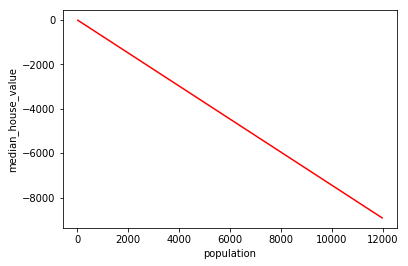

In [39]:
''' Plot data '''
# Get the min and max total_rooms values.
x_0 = sample["population"].min()
x_1 = sample["population"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/population/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("population")

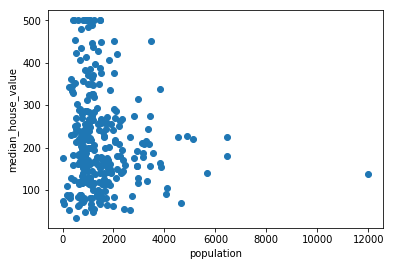

In [41]:
''' Create a scatter plot '''
# Plot a scatter plot from our data sample.
plt.scatter(sample["population"], sample["median_house_value"])

plt.xlabel("population")
plt.ylabel("median_house_value")

# Display graph.
plt.show()